# Tutorial: Picket-Fence Model

In this tutorial, we will demonstrate the usage of the MoHa package to work with the Picket-Fence Richardson-Gaudin model. 
We will show that the energy levels of the Hamiltonian are evenly spaced and explore phase transitions.

## Introduction
Picket-Fence Model is a special case with equally spaced levels of the Richardson-Gaudin Model.
The Hamiltonian is given by:
$$ \hat{H}_{RG} = \sum_p (\mu_p^Z - J_{pp}^{eq}) S_p^Z + \sum_{pq} J_{pq}^{eq} S_p^+ S_q^- $$

where:
- $\mu_p^Z$ represents the Zeeman term
- $J_{pq}^{eq}$ is the equatorial interaction term
- $S_p^{\pm}$ are spin raising/lowering operators
- $S_p^Z$ is the spin projection operator

For the picket-fence model, we have:
$$ \mu_p^Z = p\Delta $$
where:
- $\Delta$ is the level spacing.

## Setup and Implementation

We will set up the Picket-Fence model with 8 sites and a level spacing of 1.0. The coupling strength $g$ will be set to 0.5.

### Step 1: Define Model Parameters
We start by defining the number of sites, level spacing, and coupling strength.

In [81]:
# Import necessary libraries
from moha import HamRG
import numpy as np
import matplotlib.pyplot as plt
from pyscf import fci
from numpy.linalg import eigh

# Define the Picket-Fence model parameters
n_sites = 8
level_spacing = 1.0
g = 0.5

# Generate the Zeeman term
mu = np.arange(n_sites) * level_spacing

# Create the coupling matrix with diagonal elements set to zero
J_eq = np.full((n_sites, n_sites), g)
np.fill_diagonal(J_eq, 0)  # No self-interaction

# Create the Hamiltonian
ham = HamRG(mu=mu, J_eq=J_eq)

# Generate the integrals
e0 = ham.generate_zero_body_integral()
h1 = ham.generate_one_body_integral(dense=True)
h2 = ham.generate_two_body_integral(dense=True)

print("Energy levels (mu):\n", mu)
print("\nCoupling matrix (J_eq):\n", J_eq)
print("\nZero-body integral:", e0)
print("One-body integral shape:", h1.shape)
print("Two-body integral shape:", h2.shape)


Energy levels (mu):
 [0. 1. 2. 3. 4. 5. 6. 7.]

Coupling matrix (J_eq):
 [[0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0. ]]

Zero-body integral: -14.0
One-body integral shape: (16, 16)
Two-body integral shape: (16, 16, 16, 16)



Solving with PySCF FCI solver...

Error using PySCF: eri.size = 65536, norb = 8
Falling back to direct diagonalization...
Exact ground state energy: -14.29828082
Ground state energy per site: -1.78728510


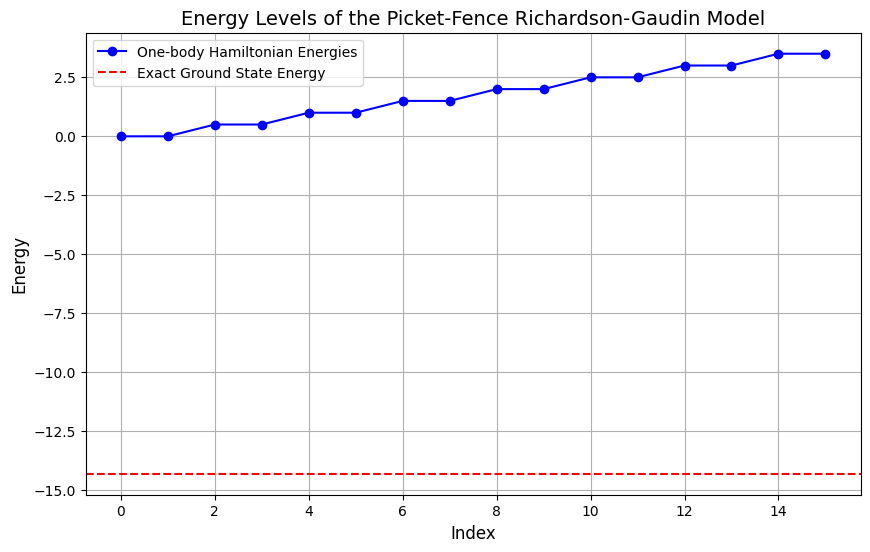

In [ ]:
# For comparison, calculate energy levels from one-body Hamiltonian
eigenvals = np.linalg.eigvals(h1)
eigenvals = np.sort(eigenvals)

# Now solve using PySCF's FCI solver
# First, convert h2 to chemist's notation as in Tutorial: Spin-based Hamiltonian
h2_chemist = np.transpose(h2, (0, 2, 1, 3))

try:
    # Use n_electrons = n_sites for half-filling
    print("\nSolving with PySCF FCI solver...")
    e_fci, ci_fci = fci.direct_spin0.kernel(h1, h2_chemist, n_sites, n_sites)
    
    # Total energy includes the zero-body term
    total_energy_fci = e_fci + e0
    print(f"FCI ground state energy: {total_energy_fci:.8f}")
    print(f"Ground state energy per site: {total_energy_fci/n_sites:.8f}")
    
    # Plot FCI results
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvals, 'o-', label='One-body Hamiltonian Energies', color='blue')
    plt.axhline(y=total_energy_fci, color='red', linestyle='--', label='PySCF FCI Ground State Energy')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Energy', fontsize=12)
    plt.title('Energy Levels of the Picket-Fence Richardson-Gaudin Model', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    use_pyscf = True
    
except Exception as e:
    print(f"\nError using PySCF: {e}")
    print("Falling back to direct diagonalization...")
    use_pyscf = False
    
    # Define Pauli spin matrices for exact diagonalization
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    I = np.array([[1, 0], [0, 1]])
    
    # Define function for Kronecker product with identity
    def kron_id(matrix, N, L):
        """Creates Kronecker product of matrix with identity matrices."""
        result = matrix
        for _ in range(N):
            result = np.kron(I, result)
        
        for _ in range(L-N-1):
            result = np.kron(result, I)
        return 1/2*result
    
    # Define function to create spin operators on Nth site
    def spin_operator(operator, N, L):
        """Creates a spin operator (Sx, Sy, Sz) on the Nth site."""
        return kron_id(operator, N, L)
    
    # Create spin operators for each site
    Sx = [spin_operator(sigma_x, i, n_sites) for i in range(n_sites)]
    Sy = [spin_operator(sigma_y, i, n_sites) for i in range(n_sites)]
    Sz = [spin_operator(sigma_z, i, n_sites) for i in range(n_sites)]
    
    # Construct the Hamiltonian explicitly
    H_explicit = np.zeros((2**n_sites, 2**n_sites), dtype=complex)
    
    # Add Zeeman terms
    for i in range(n_sites):
        H_explicit += mu[i] * Sz[i]
    
    # Add interaction terms
    for i in range(n_sites):
        for j in range(n_sites):
            if i != j:  # Skip self-interactions
                # XY interaction (S+S-) = 0.5*(SxSx + SySy)
                H_explicit += g * (Sx[i] @ Sx[j] + Sy[i] @ Sy[j])
    
    # Calculate eigenvalues and eigenvectors
    exact_eigenvalues, exact_eigenvectors = eigh(H_explicit)
    total_energy = exact_eigenvalues[0].real  # Ground state energy
    
    print(f"Exact ground state energy: {total_energy:.8f}")
    print(f"Ground state energy per site: {total_energy/n_sites:.8f}")
    
    # Plot the energy levels from both methods
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvals, 'o-', label='One-body Hamiltonian Energies', color='blue')
    plt.axhline(y=total_energy, color='red', linestyle='--', label='Exact Ground State Energy')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Energy', fontsize=12)
    plt.title('Energy Levels of the Picket-Fence Richardson-Gaudin Model', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

## Phase Transitions

We will now explore the phase transitions in the Picket-Fence Richardson-Gaudin model by varying the coupling strength $g$.

### Step 2: Vary Coupling Strength
We will vary the coupling strength from 0.1 to 2.0 and observe the changes in the ground state energy.

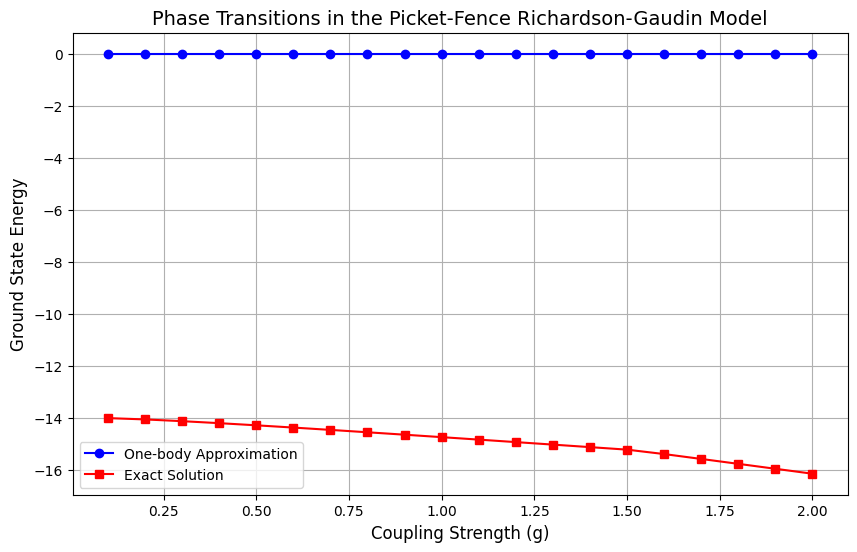

In [ ]:
g_values = np.linspace(0.1, 2.0, 20)
ground_state_energies = []  # One-body approximation
exact_ground_energies = []  # Exact diagonalization

for g_val in g_values:
    J_eq_g = np.full((n_sites, n_sites), g_val)
    np.fill_diagonal(J_eq_g, 0)  # No self-interaction
    
    # Create the Hamiltonian
    ham_g = HamRG(mu=mu, J_eq=J_eq_g)
    
    # One-body approximation
    h1_g = ham_g.generate_one_body_integral(dense=True)
    eigenvals_g = np.linalg.eigvals(h1_g)
    ground_state_energies.append(np.min(eigenvals_g))
    
    if use_pyscf:
        e0_g = ham_g.generate_zero_body_integral()
        h2_g = ham_g.generate_two_body_integral(dense=True)
        h2_chemist_g = np.transpose(h2_g, (0, 2, 1, 3))
        
        try:
            e_g, _ = fci.direct_spin0.kernel(h1_g, h2_chemist_g, n_sites, n_sites)
            exact_ground_energies.append(e_g + e0_g)
        except Exception:
            # If PySCF fails, fall back to direct diagonalization for this g value
            H_g = np.zeros((2**n_sites, 2**n_sites), dtype=complex)
            
            #Zeeman terms
            for i in range(n_sites):
                H_g += mu[i] * Sz[i]
            
            #interaction terms
            for i in range(n_sites):
                for j in range(n_sites):
                    if i != j:
                        H_g += g_val * (Sx[i] @ Sx[j] + Sy[i] @ Sy[j])
            
            #find ground state energy
            exact_eigenvalues_g = np.linalg.eigvalsh(H_g)
            exact_ground_energies.append(np.min(exact_eigenvalues_g.real))
    else:
        #use direct diagonalization for exact solution
        H_g = np.zeros((2**n_sites, 2**n_sites), dtype=complex)

        for i in range(n_sites):
            H_g += mu[i] * Sz[i]

        for i in range(n_sites):
            for j in range(n_sites):
                if i != j:
                    H_g += g_val * (Sx[i] @ Sx[j] + Sy[i] @ Sy[j])

        exact_eigenvalues_g = np.linalg.eigvalsh(H_g)
        exact_ground_energies.append(np.min(exact_eigenvalues_g.real))

# Plot the ground state energy as a function of coupling strength
plt.figure(figsize=(10, 6))
plt.plot(g_values, ground_state_energies, 'o-', label='One-body Approximation', color='blue')
plt.plot(g_values, exact_ground_energies, 's-', label='Exact Solution', color='red')
plt.xlabel('Coupling Strength (g)', fontsize=12)
plt.ylabel('Ground State Energy', fontsize=12)
plt.title('Phase Transitions in the Picket-Fence Richardson-Gaudin Model', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()